In [1]:
#Cell 1: Setup & Training with VGG16
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input  # Changed to VGG16
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight

print(f"TensorFlow version: {tf.__version__}")
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU devices:", tf.config.list_physical_devices('GPU'))

# Parameters
img_size = (280, 280)
batch_size = 32
epochs_initial = 20
epochs_finetune = 10

train_dir = './train'   
valid_dir = './valid'   

# Label helper
def get_label(fname):
    fname = fname.lower()
    if fname.startswith('autistic'):
        return 0
    elif fname.startswith('non_autistic'):
        return 1
    else:
        return None

# Prepare train filenames and labels
train_filenames = []
train_labels = []
for fname in os.listdir(train_dir):
    label = get_label(fname)
    if label is not None:
        train_filenames.append(fname)
        train_labels.append(label)
print(f"Loaded {len(train_filenames)} training samples.")

# Face detection cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def detect_and_crop_face(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Could not read image {img_path}")
        return None
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4)
    if len(faces) == 0:
        return None
    faces = sorted(faces, key=lambda x: x[2]*x[3], reverse=True)
    (x, y, w, h) = faces[0]
    face_img = img[y:y+h, x:x+w]
    face_img = cv2.resize(face_img, img_size)
    return cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)

def train_generator(filenames, labels, directory, datagen, batch_size, shuffle=True):
    n = len(filenames)
    indices = np.arange(n)
    while True:
        if shuffle:
            np.random.shuffle(indices)
        for start in range(0, n, batch_size):
            end = min(start + batch_size, n)
            batch_idx = indices[start:end]
            batch_imgs, batch_lbls = [], []
            for i in batch_idx:
                img_path = os.path.join(directory, filenames[i])
                face_img = detect_and_crop_face(img_path)
                if face_img is None:
                    img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
                    face_img = np.array(img)
                batch_imgs.append(face_img)
                batch_lbls.append(labels[i])
            batch_imgs = np.array(batch_imgs, dtype=np.float32)
            batch_imgs = preprocess_input(batch_imgs)
            batch_imgs = datagen.standardize(batch_imgs)
            yield batch_imgs, np.array(batch_lbls)

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_steps = len(train_filenames) // batch_size

print("Creating generators...")
train_gen = train_generator(train_filenames, train_labels, train_dir, train_datagen, batch_size)

valid_gen = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

valid_steps = valid_gen.samples // batch_size

# Class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

# Model building with VGG16
input_layer = Input(shape=img_size + (3,))
base_model = VGG16(include_top=False, weights='imagenet', input_tensor=input_layer)  # Changed to VGG16

# Freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)

print("Starting initial training...")
history = model.fit(
    train_gen,
    steps_per_epoch=train_steps,
    validation_data=valid_gen,
    validation_steps=valid_steps,
    epochs=epochs_initial,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr],
    workers=1,
    use_multiprocessing=False
)

print("Initial training complete.")

# Unfreeze last 4 blocks for fine-tuning (VGG16 has 5 blocks)
print("Unfreezing last 4 blocks for fine-tuning...")
for layer in base_model.layers[-15:]:  # Adjust based on VGG16 architecture
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("Starting fine-tuning...")
train_gen_finetune = train_generator(train_filenames, train_labels, train_dir, train_datagen, batch_size)
history_finetune = model.fit(
    train_gen_finetune,
    steps_per_epoch=train_steps,
    validation_data=valid_gen,
    validation_steps=valid_steps,
    epochs=epochs_finetune,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr],
    workers=1,
    use_multiprocessing=False
)

print("Fine-tuning complete.")
model.save('vgg16_model.h5')  # Changed model name

TensorFlow version: 2.10.0
Num GPUs Available: 1
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Loaded 2540 training samples.
Creating generators...
Found 100 images belonging to 2 classes.
Class weights: {0: 1.0, 1: 1.0}
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 280, 280, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 280, 280, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 280, 280, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 140, 140, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 140, 140, 128)     73856     
    

Evaluating on validation set...
3/3 [==============================] - 1s 279ms/step
Validation samples: 96
Correct predictions: 75
Wrong predictions: 21


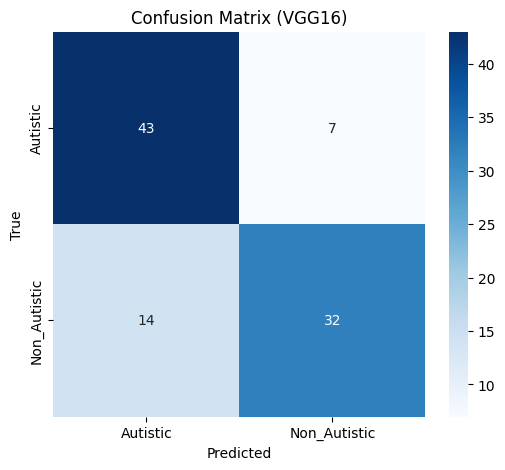

Classification Report:
              precision    recall  f1-score   support

    Autistic       0.75      0.86      0.80        50
Non_Autistic       0.82      0.70      0.75        46

    accuracy                           0.78        96
   macro avg       0.79      0.78      0.78        96
weighted avg       0.79      0.78      0.78        96



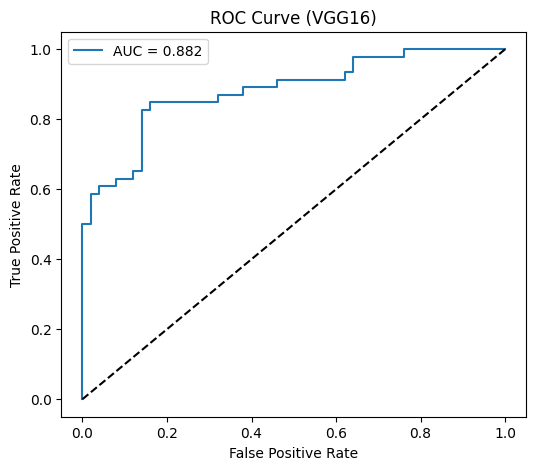

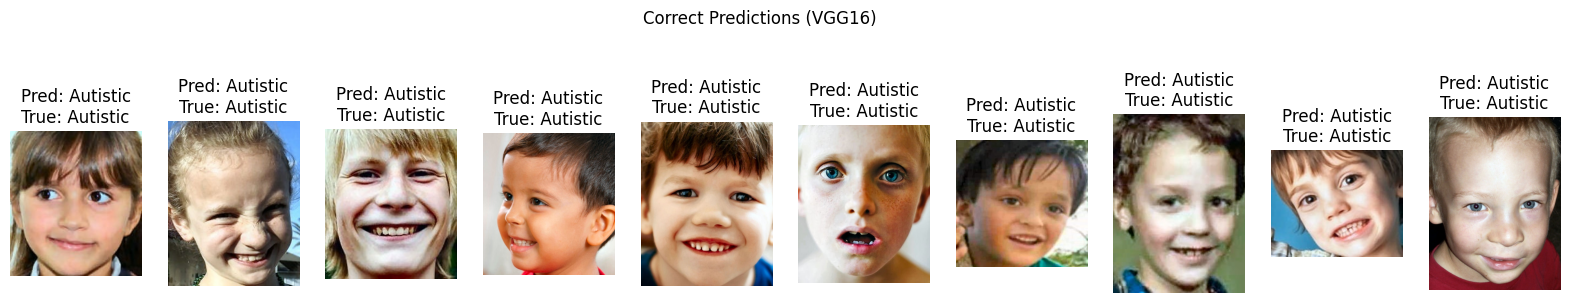

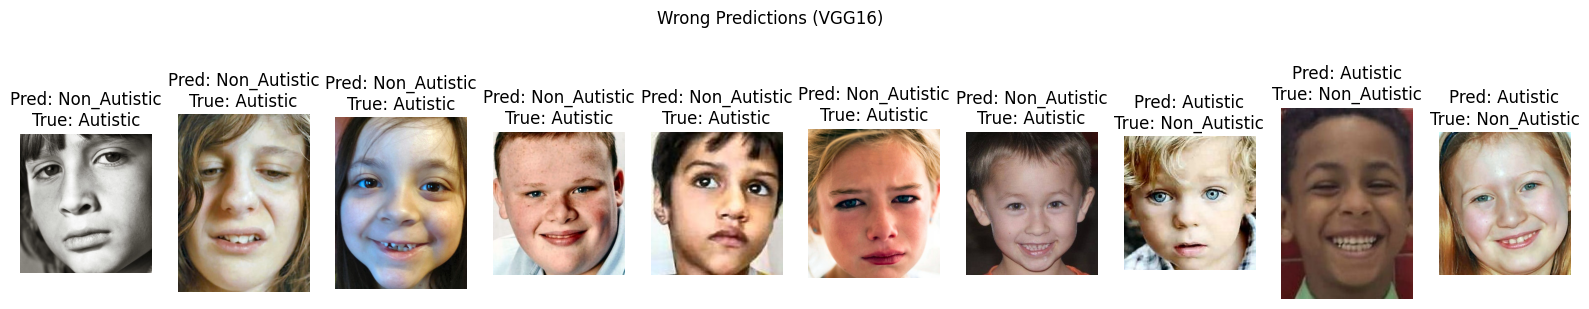

In [2]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Evaluate on full validation set
print("Evaluating on validation set...")
val_preds_prob = model.predict(valid_gen, steps=valid_steps, verbose=1)
val_preds = (val_preds_prob > 0.5).astype(int).flatten()

val_true = valid_gen.classes[:len(val_preds)]  # Make sure lengths match
val_filenames = valid_gen.filenames[:len(val_preds)]
class_names = list(valid_gen.class_indices.keys())

print(f"Validation samples: {len(val_true)}")
print(f"Correct predictions: {(val_preds == val_true).sum()}")
print(f"Wrong predictions: {(val_preds != val_true).sum()}")

# Confusion matrix
cm = confusion_matrix(val_true, val_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (VGG16)')  # Updated title
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(val_true, val_preds, target_names=class_names))

# ROC Curve
fpr, tpr, _ = roc_curve(val_true, val_preds_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (VGG16)')  # Updated title
plt.legend()
plt.show()

# Plot examples of correct and wrong predictions
def plot_examples(indices, title, max_imgs=10):
    plt.figure(figsize=(20,4))
    for i, idx in enumerate(indices[:max_imgs]):
        img_path = os.path.join(valid_dir, val_filenames[idx])
        img = plt.imread(img_path)
        plt.subplot(1, max_imgs, i+1)
        plt.imshow(img)
        plt.title(f"Pred: {class_names[val_preds[idx]]}\nTrue: {class_names[val_true[idx]]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

correct_idx = np.where(val_preds == val_true)[0]
wrong_idx = np.where(val_preds != val_true)[0]

plot_examples(correct_idx, "Correct Predictions (VGG16)")  # Updated title
plot_examples(wrong_idx, "Wrong Predictions (VGG16)")  # Updated title

In [5]:
test_dir = './test'  # Folder with unlabeled test images
test_filenames = os.listdir(test_dir)
test_df = pd.DataFrame({'filename': test_filenames})

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='filename',
    y_col=None,
    target_size=img_size,
    batch_size=1,
    class_mode=None,
    shuffle=False
)

print("Predicting on test set with VGG16...")  # Updated message
test_preds_prob = model.predict(test_gen, verbose=1)
test_preds = (test_preds_prob > 0.5).astype(int).flatten()

print("\nTest Predictions (VGG16):")  # Updated header
for fname, pred in zip(test_gen.filenames, test_preds):
    label = 'Autistic' if pred == 0 else 'Non_Autistic'
    #print(f"{fname}: {label} (Confidence: {test_preds_prob[test_gen.filenames.index(fname)][0]:.3f})")
    print(f"{fname}: {label} ")

# Single image prediction helper (VGG16-compatible)
def predict_image(img_path):
    img = detect_and_crop_face(img_path)
    if img is None:
        print("No face detected, resizing full image")
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, img_size)
    x = np.expand_dims(img, axis=0)
    x = preprocess_input(x.astype(np.float32))  # Using VGG16's preprocessing
    pred_prob = model.predict(x)[0][0]
    pred_label = 'Autistic' if pred_prob < 0.5 else 'Non_Autistic'
    #print(f"VGG16 Prediction: {pred_label} (Confidence: {pred_prob:.3f})")
    print(f"VGG16 Prediction: {pred_label}")
    plt.imshow(img)
    plt.title(f"VGG16 Prediction: {pred_label}")  # Updated title
    plt.axis('off')
    plt.show()

# Example usage:
# predict_image('path/to/single/image.jpg')

Found 300 validated image filenames.
Predicting on test set with VGG16...
300/300 [==============================] - 2s 5ms/step

Test Predictions (VGG16):
Autistic.0.jpg: Autistic 
Autistic.1.jpg: Autistic 
Autistic.10.jpg: Autistic 
Autistic.100.jpg: Autistic 
Autistic.101.jpg: Autistic 
Autistic.102.jpg: Autistic 
Autistic.103.jpg: Autistic 
Autistic.104.jpg: Autistic 
Autistic.105.jpg: Autistic 
Autistic.106.jpg: Autistic 
Autistic.107.jpg: Autistic 
Autistic.108.jpg: Autistic 
Autistic.109.jpg: Autistic 
Autistic.11.jpg: Non_Autistic 
Autistic.110.jpg: Autistic 
Autistic.111.jpg: Autistic 
Autistic.112.jpg: Autistic 
Autistic.113.jpg: Autistic 
Autistic.114.jpg: Autistic 
Autistic.115.jpg: Non_Autistic 
Autistic.116.jpg: Autistic 
Autistic.117.jpg: Autistic 
Autistic.118.jpg: Autistic 
Autistic.119.jpg: Autistic 
Autistic.12.jpg: Autistic 
Autistic.120.jpg: Autistic 
Autistic.121.jpg: Autistic 
Autistic.122.jpg: Autistic 
Autistic.123.jpg: Autistic 
Autistic.124.jpg: Autistic 
Aut